### Реализация и исследование L-BFGS

L-BFGS (L - limited mempry) --- модификация метода BFGS с ограниченной памятью. 
Обычный BFGS хранит приближение к обратному гессиану в виде квадратной неразряженной матрицы и это может потреблять очень большой обьём памяти в случаях, когда число переменных огромное. В таких случаях может быть использован LBFGS.

Идея в том, что вместо целой матрицы хранится ограниченная (числом m) история изменений позиции $\Delta x$ и градиента $\Delta \nabla f(x)$, на основе которых на каждом шагу приближается обратный к гессиану и вычиялется направление поиска. Часто это число m < 20

In [172]:
from matplotlib import pyplot as plt
import numpy as np
import random as rand
from collections import deque
plt.rcParams["figure.figsize"] = (20,10)

In [173]:
class History:
    s = None # dx
    y = None
    rho = None

    def __init__(self, m = 5):
        self.s = deque([], m)
        self.y = deque([], m)
        self.rho = deque([], m)

    def update(self, dx, dg):
        self.s.appendleft(dx)
        self.y.appendleft(dg)
        self.rho.appendleft(1. / (np.dot(dg, dx) + 1e-30))

In [174]:
def wolfe_search(f, x, p, grad, nabla, max_it = 20):
    '''
    Поиск с условиями Вольфе
    '''
    a = 1
    c1 = 1e-4 
    c2 = 0.9 
    fx = f(*x)

    x_new = x + a * p 
    nabla_new = np.array(grad(*x_new))
    for _ in range(0, max_it):
        if not (f(*x_new) >= fx + (c1*a*np.array(nabla).T @ p) or nabla_new.T @ p <= c2*(np.array(nabla)).T @ p):
            break 
        a *= 0.5
        x_new = x + a * p 
        nabla_new = np.array(grad(*x_new))
    return a

In [175]:
def get_direction(grad, history, h_init):
    q = np.copy(grad)
    m = len(history.rho)
    alpha = np.zeros(m)

    for i in range(m - 1, -1, -1):
        alpha[i] = history.rho[i] * np.dot(history.s[i], q)
        q = q - alpha[i] * history.y[i]

    if m == 0:
        H_init = h_init
        if isinstance(h_init, np.ndarray):
            r = np.matmul(H_init, q.reshape(-1, 1)).T[0]
        else:
            r = H_init * q
    else:
        H_init = np.dot(history.s[-1], history.y[-1]) / (np.dot(history.y[-1], history.y[-1]) + 1e-30)
        r = H_init * q

    for i in range(m):
        r = r + history.s[i] * (alpha[i] - history.rho[i] * np.dot(history.y[i], r))

    return -r

In [176]:
def lbfgs(f_batch, batch_size, x0, grad, m = 5, eps = 1e-9, epochs=100, h_init=1, **config):
    x = np.copy(x0)
    points_history = [x]
    g = np.array(grad(*x))
    history = History(m)

    f = f_batch(batch_size)

    for epoch in range(0, epochs):
        print(epoch)
        if not (np.linalg.norm(g) > eps and epoch <= epochs):
            break

        d = get_direction(g, history, h_init=h_init)
        a = wolfe_search(f, x, d, grad, grad(*x)) # поиск с условиями Вольфе 
        # s = np.array([a * p]) # величина шага (dx)
        x_new = np.array(x + a * d)
        
        g_new = np.array(grad(*x_new))
        history.update(x_new - x, g_new - g)
        x = x_new
        g = g_new
        points_history.append(x_new)
        epoch += 1
    return points_history

### Тест

Предлагается тест LBFGS на задаче линейной регрессии с очень большой размерностью.

In [177]:
rand = lambda n: (np.random.rand(n)*2)-1

def random_perfect_line(n, k, k_limit, ms_limit, debug=False):
    m = rand(n) * ms_limit
    s = rand(n) * ms_limit
    ks = rand(k) * k_limit
    xy = np.array([m + s * k for k in ks])
    x = xy[:, :-1]
    y = xy[:, -1]
    return x, y

In [178]:
def grad_batch(f_batch_size, batch_size):
    def grad_help(*args):
        h = 1e-10
        dim = len(args)
        f = f_batch_size(batch_size)
        return [(
                        f(*[args[j] + (h if j == i else 0) for j in range(dim)])
                        -
                        f(*[args[j] - (h if j == i else 0) for j in range(dim)])
                ) / (2 * h)
                for i in range(dim)]
    return grad_help

In [179]:
def regression(x, y, method, batch_size=10, **config):
    if config == {}:
        config = {"lr0": 0.5, "d": 0.005, "epoch": 1000}
    x_mat = np.hstack((np.ones((x.shape[0], 1)), x))
    n = x_mat.shape[1] # the dimenstion 
    print(f'{n=}')

    batch_choice = lambda batch_size: list(set(np.random.choice(np.arange(x.shape[0]), batch_size, replace=False)))    
    f_batch = lambda batch_size: \
                       lambda *b, batch=batch_choice(batch_size): \
                           np.linalg.norm(y[batch] - x_mat[batch].dot(b))
    
    bs = np.array(method(f_batch, batch_size, np.full(n, 1), grad_batch(f_batch, batch_size)))
    
    f = f_batch(x.shape[0]) # the entire function 
    print(f'came close by {f(*bs[-1])}')
    ax = plt.figure().add_subplot()
    X = np.arange(len(bs))
    ax.plot(X, np.array([f(*x.T) for x in bs]))
    ax.grid()
    return bs

In [180]:
line = random_perfect_line(25, 100, 100, 100)

n=100
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
came close by 1.6790056703531541e-09


array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.85400345, 0.84324484, ..., 0.77872756, 1.17945756,
        0.85731747],
       [0.99999917, 0.92697128, 0.92167111, ..., 0.88926542, 1.08978645,
        0.928673  ],
       ...,
       [1.00436948, 0.88161842, 1.16300631, ..., 0.61184902, 1.21242693,
        1.0260268 ],
       [1.00436948, 0.88161842, 1.16300631, ..., 0.61184902, 1.21242693,
        1.0260268 ],
       [1.00436948, 0.88161842, 1.16300631, ..., 0.61184902, 1.21242693,
        1.0260268 ]])

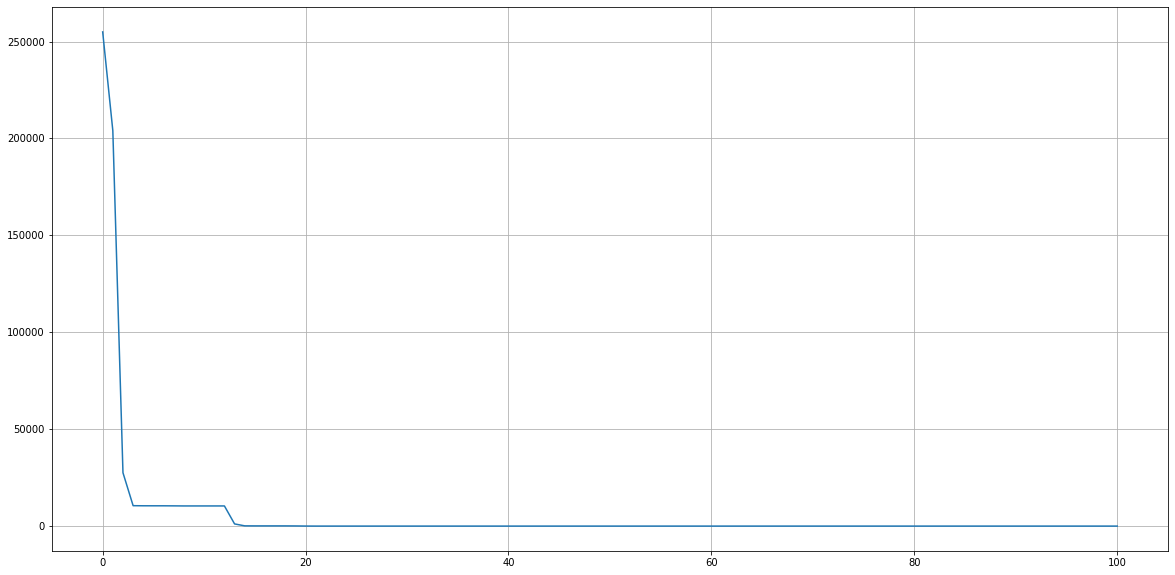

In [181]:
regression(*line, lbfgs, batch_size = 100)